[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1QmRvbIn6kuphxtUToLZK1vxoGxk5baTS#scrollTo=0E9SzZDpeEhL)


# **OCR Model Training**




###**Installing and Importing Required Libraries**


---



1. OpenCV - Image Processing Library
2. Tensorflow 2.0 - Machine learning Library

In [0]:
!pip install tensorflow==2.0rc1

from IPython.display import clear_output
import cv2 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

clear_output()

###**Getting The DATASET from the repository**


---


This will clone git repository. The hierarchy of this repository as shown below:

          OCR -+-> data -----+--> a
               |             +--> b
               +-> other     :
                   files     :
                             +--> noise
                             

In [0]:
from getpass import getpass
user = getpass('GitHub UserName : ')
password = getpass('GitHub Password : ')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/abhinandanarya06/OCR.git

clear_output()

###**Function to show image**


---


"***imshow(image)***" function show image given as parameter

In [0]:
def imshow(image):
  plt.imshow(image, cmap = 'gray', interpolation = 'bicubic')
  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()

###**Mapping Letters classes to numbers**
Keywords contains letters with appropriate index number mapping

In [0]:
keywords = [chr(c) for c in range(ord('a'), ord('z')+1)]
cap = ['A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'Q', 'R', 'T']
keywords = keywords + cap
keywords = keywords + ['noise']

In [44]:
print(len(keywords))

41


###**Preparing Data for Training**

---



In [0]:
data_images = list()
labels = list()
i = 0
for c in keywords:
  path = 'OCR/data/{}/'.format(c) # IF YOU WANT TO GET DATA FROM OTHER PATH,
  files = os.listdir(path)        # THEN PLEASE MODIFY "path" VARIABLE ACCORDINGLY
  for name in files:
      img = cv2.imread(path+name)
      try:
        img = cv2.resize(img, (50, 50), interpolation = cv2.INTER_AREA)
      except:
        continue
      data_images.append(img)
      labels.append(i)
  i += 1


In [0]:
data_images = np.array(data_images)
labels = np.array(labels)

In [47]:
print(labels.shape, data_images.shape)

(48183,) (48183, 50, 50, 3)


###**Model Architecture**


---


Layer Sequence (Sequencial Model) : 


1.   Conv2D Layer
2.   Flatten Operation
3.   Dense Layer with 200 units
4.   10% neuron Dropout Operation
5.   Dense Layer with 41 units




In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = (50, 50, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(keywords))
])

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               14745800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 41)                8241      
Total params: 14,754,937
Trainable params: 14,754,937
Non-trainable params: 0
_________________________________________________________________


**Training starts with callback of early stopping with patience 2**

---



In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
model.fit(data_images, labels, epochs=10, callbacks = [callback])
clear_output()

In [52]:
test_loss, test_acc = model.evaluate(data_images,  labels, verbose=2)

print('\nTest accuracy:', test_acc)

48183/1 - 61s - loss: 0.0379 - accuracy: 0.9883

Test accuracy: 0.9882946




---


---





# **OCR Model Testing**


 

###**Saving the trained model**


---

'model' model is saved in current directory with name 'model.hd5'


In [0]:
model.save('model.h5')
clear_output()

### **Load Model**

---



In [0]:
model = tf.keras.models.load_model('model.h5')

####**Adding Softmax Activation**

---



In [0]:
text_detector = tf.keras.Sequential(
    model,
    tf.keras.layers.Softmax()
)

### **OCR Deployment Demo (Testing Model)**


---



#####**Some Conventions**

In [0]:
X = 0   # X coordinate of the character in image space
Y = 1   # Y coordinate of the character in image space
POS = 1    # shows and return the (x,y) coordinate of image space
SHAPE = 2  # shows and return the (width, height) of character contour in image space
W = 0 # width of the character
H = 1 # height of the character

#####"***check_in(c, region)***" checks if character is present in the given region "*region*" of the image space

In [0]:
def check_in(c, region):
    x, y, w, h = region
    center_x = c[POS][X]+c[SHAPE][W]/2
    center_y = c[POS][Y]
    if (center_x > x-1 and center_x < x+w+1) and (center_y > y-1 and center_y < y+h+1):
        return True
    return False

#####"***get_region(c, regions)***" finds the region in the given list of regions "*regions*" in image space and return it

In [0]:
def get_region(c, regions):
    for region in regions:
        if check_in(c, region):
          return region
    return False

#####"***sort_chars(line)***" Function to sort characters in given line

In [0]:
def sort_chars(line):
  res = list()
  while len(line) > 0:
    mx = 100000
    m = 0
    for c in line:
      if c[POS][X] <= mx:
        mx = c[POS][X]
        m = c
    line.remove(m)
    res.append(m)
  return res

#####"***sort_lines_by_yval(lines)***" function sorts list of lines according to its y coordinate in image space

In [0]:
def sort_lines_by_yval(lines):
  res = list()
  while len(lines) > 0:
    mn = 100000
    m = 0
    for line in lines:
      if line[0][POS][Y] < mn:
        mn = line[0][POS][Y]
        m = line
    lines.remove(m)
    res.append(m)
  return res

#####"***arrangeline(characters)***" Function to group characters in given image by lines

In [0]:
def group_chars_by_line(characters):
  lines = list()
  linei = 0
  while len(characters) > 0:
      m = characters[0]
      my = m[1][1]
      my_plus_h = m[1][1]+m[2][1]
      lines.append([m])
      for c in characters[1:]:
          if my <= c[POS][Y]+c[SHAPE][H]/2 and c[POS][Y]+c[SHAPE][H]/2 <= my_plus_h:
              if my > c[POS][Y]:
                my = c[POS][Y]
              if my_plus_h < c[POS][Y]+c[SHAPE][H]:
                my_plus_h = c[POS][Y]+c[SHAPE][H]
              lines[linei].append(c)
              characters.remove(c)
      lines[linei]= sort_chars(lines[linei])
      linei += 1
      characters.remove(m)
  return lines

#####"***apply_ocr(img)***" is the function that does actual ocr operation on image parameter to get text

In [0]:
def apply_ocr(img, text_detector):
    avg_h = 0
    character_list = list()
    color = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.medianBlur(img,5)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,21,10)
    contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    img[:,:]=0
    i = 0
    for c in contours:
      try:
        x,y,w,h = cv2.boundingRect(c)
        try:
            show = color[y-2:y+h+2, x-2:x+w+2]
        except:
            show = color[y:y+h, x:x+w]
        test_data = cv2.resize(show,(50,50),interpolation = cv2.INTER_AREA)
        test_data=np.array([test_data])
        cmd = np.argmax(text_detector.predict(test_data))
        if cmd < 40:
          avg_h += h
          cv2.rectangle(img, (x,y), (x+w+w//4, y+h), 255, -1)
          character_list.append([keywords[cmd], (x,y), (w,h)])
          i+= 1
      except:
            continue
    avg_h/=i
    text = group_chars_by_line(character_list)#, img)
    text = sort_lines_by_yval(text)
    contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    regions = list()
    for cnt in contours:
      region = cv2.boundingRect(cnt)
      if region[3] <= avg_h*7:
        regions.append(region)
    del contours

    TEXT = ''
    for l in text:
      char = l[0]
      region = get_region(char, regions)
      if not region:
        continue
      for char in l:
        if not check_in(char, region):
          TEXT = TEXT + ' '
          r = get_region(char, regions)
          if not r:
            continue
          region = r
        TEXT = TEXT + char[0]
      TEXT = TEXT + '\n'
    return TEXT

#####**Main Run Start Point**

---



* Before running this start point, Please check if 
 *test_image_path* variable have path to your own test images or not.
* If not, please modify the path variable

****************************** Text on 20200409_131401.jpg ******************************


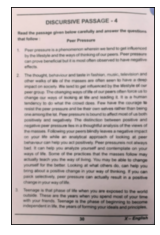

D scuRs vE pAssAGE
Read t e passape piven heiov cerefu y and answer t e fuestions
that fol iovv peer pressure
r peetr pressure is e phenomenon where n we tend to get nfuenced
by the iifestyie and the ways of thinking of our peers peer pressure
n prove benefciei but it s most often ohsewed to have negetive
effects
c The thought heheviour and taste in feshion music te evision end
other weiks of iife of the masses ere often seen to heve e deep
impact on society we tend to get infuenced by the i festyie of our
peer proup The chenpinp weys of iife of our pee ohen force us to
chenpe our weys of ooking et ife end ieeding t i t is e humen
tendency to do whet the crowd does Few heve the courege to
res st the peer pressure end he their own seives rather then bei ng
one among the iot peer pressure is bound to affect most of us both
positive y end negat veiy The distinction be een positive and
negative peer pressure i es in a thoughtfui eneiysis of the views of
the messes Foiiowing your peers hiin

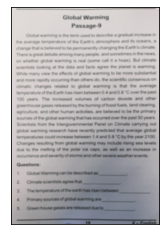

G obe wsrm nv
psssage s
G bv h d d h due ncreese n
oe wermi ng i s te term use to escr e e gre
t e everege tempereture of the Ea h s etmosphere end ts oceens e
chenge thet i s be eved to be permanent y cheng ng the Ee h s c i mete
There ls greet debete emong many peop e end somet mes i n the news
on whether g obe werm ng i s ree some ce t e hoex But c i mete
scl entlsts eokl ng et the dete and fects agree the p enet i s wermi ng
whl e meny vl ew the eiects of g obe werm ng to be more substanti e
end more repl d y occurr ng then others do the sci ent fc consensus on
c metlc chenges re eted to g oba warmi ng s that the everege
tempereture of the Ee h has rlsen between o and o B nc over the pest
n oo yeers The l ncreased vo umes of carbon d ox de and other
greenhouse geses re eased by the burnl ng of fossi l fue s and c eari ng
egr cu ture end other human actlvi ti es are bel i eved to be the pri maw
seurces of the g obal warmi ng that has occurred over the past so years
scl entI sts from

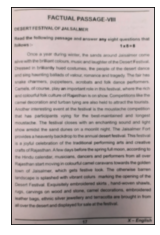

FAcTuAL pAss GE v
eEsER FEsT v L oF j Ls LvER
etad t e fe o r nr pessejve end enswer eny eivhl fuestions hat
fo ovvs B B
once a yeer duri nq w nter the sends eround ua se mer Eome
e ve th the br i ent co ours mus c end euqhter of the Dese FestiveRi
oressed i n bn ient y hued costumes the peop e of the dese dence
end s nq heunt ng ha ieds of ve our romence end treqedy The fe r hes
sTeke chermers puppeteers ecrohets and fo k dence peformers
came s of course p ey an i mpo ant ro e n this festiva where the r ch
and co oufu fo k cu ture of Rejasthan s on show competitions ike the
me hecoretion end turben ty ng ere aiso he d to ettrect the touri sts
nother nteresti ng event et the festivei is the mousteche compet tion
thet has pe ici pents i ng for the best mei nta ned end ongest
moustache The festive c oses with en enchanti ng sound and iqht
show emidst the sand dunes on e moon it night The jaisai mer Foh
provides e heaven y beckdrop to the ennuei dese festiva Th s festive
s a joyfu ce ehre

In [62]:
test_images_path = '.' # IF YOU PLACE TEST IMAGE INSIDE OCR DIRECTORY,
                       # THEN PLEASE MODIFY "test_images_path" variable


imgs = [f for f in os.listdir(test_images_path) if f.endswith('.jpg')]
img_no = 0
for img in imgs:
    print('*'*30, 'Text on {}'.format(img), '*'*30)
    img = cv2.imread(img)
    TEXT = apply_ocr(img, text_detector)
    imshow(img)
    print(TEXT)
    print('-'*80, '\n\n')
    img_no += 1